In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# import eli5
# import shap

%matplotlib inline

In [417]:
colors = ['#e16b8c','#f8c3cd','#b5495b','#b28fce','#f8c3cd', '#b5495b','#8e354a', '#70649a']


In [418]:
data_raw = pd.read_csv("data/Hotel Reservations.csv")
data_raw.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# 1. Data Cleaning

**Dropping Columns to Omit**

In [419]:
rsvn = data_raw.drop(columns=['Booking_ID', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_special_requests'])

**Binary Columns**

1. Children Column
Converting numeric column "no_children" to binary column "children", where 1 means there are children, and 0 meaning no children. 

In [420]:
def children(n):
    if n == 0:
        return 0
    else:
        return 1

In [421]:
rsvn['no_of_children'] = rsvn['no_of_children'].apply(children)
rsvn.rename(columns={'no_of_children': 'children'}, inplace=True)

**Previous Cancellations Calculation**

Adding new column "cx_rsvn_pcg" for % canceled reservations calculated as follows: no_of_previous_cancellations/(no_of_previous_cancellations+no_of_previous_bookings_not_canceled)

In [422]:
def get_canceled_rsvn_pcg(cancelled, not_cancelled):
    total = cancelled + not_cancelled
    if total == 0 : 
        return 0
    else: 
        return cancelled/total

rsvn['cx_rsvn_pcg'] = rsvn.apply(lambda x: get_canceled_rsvn_pcg(x.no_of_previous_cancellations, x.no_of_previous_bookings_not_canceled), axis=1)
rsvn.drop(columns=['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'], inplace=True)

**Total Number of Nights Column**

New column "total number of nights" as sum of columns "no_of_weekend_nights" and "no_of_week_nights"

In [423]:
week_nights = rsvn['no_of_week_nights']
weekend_nights = rsvn['no_of_weekend_nights']
nights_ttl = week_nights + weekend_nights
rsvn['nights_ttl'] = nights_ttl
rsvn.drop(columns=['no_of_weekend_nights', 'no_of_week_nights'], inplace=True)

In [424]:
rsvn.head()

,no_of_adults,children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,Not_Canceled,0.0,3
1,2,0,Not Selected,0,Room_Type 1,5,Online,0,106.68,Not_Canceled,0.0,5
2,1,0,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,Canceled,0.0,3
3,2,0,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,Canceled,0.0,2
4,2,0,Not Selected,0,Room_Type 1,48,Online,0,94.50,Canceled,0.0,2


### 1.4 Target Column: Booking Status Column
Turn booking_status column to a binary column (Not canceled = 0, Canceled = 1)

In [425]:
# def booking_status(s):
#     if s == "Not_Canceled":
#         return 0
#     else:
#         return 1
    
# rsvn['booking_status']=rsvn['booking_status'].apply(booking_status)

rsvn_sum1 = rsvn.describe()[[True,True,True,True,False, False,False, True]]
rsvn_sum1

In [426]:
rsvn_sum2 = rsvn.info()
rsvn_sum2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                36275 non-null  int64  
 1   children                    36275 non-null  int64  
 2   type_of_meal_plan           36275 non-null  object 
 3   required_car_parking_space  36275 non-null  int64  
 4   room_type_reserved          36275 non-null  object 
 5   lead_time                   36275 non-null  int64  
 6   market_segment_type         36275 non-null  object 
 7   repeated_guest              36275 non-null  int64  
 8   avg_price_per_room          36275 non-null  float64
 9   booking_status              36275 non-null  object 
 10  cx_rsvn_pcg                 36275 non-null  float64
 11  nights_ttl                  36275 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.3+ MB


In [427]:
rsvn.head()

,no_of_adults,children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,Not_Canceled,0.0,3
1,2,0,Not Selected,0,Room_Type 1,5,Online,0,106.68,Not_Canceled,0.0,5
2,1,0,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,Canceled,0.0,3
3,2,0,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,Canceled,0.0,2
4,2,0,Not Selected,0,Room_Type 1,48,Online,0,94.50,Canceled,0.0,2


In [428]:
names = ['no_of_adults', 'children', 'type_of_meal_plan',
       'required_car_parking_space', 'room_type_reserved', 'lead_time',
       'market_segment_type', 'repeated_guest', 'avg_price_per_room','cx_rsvn_pcg', 'nights_ttl']
interp = ['Number of adults',
          'Number of Children',
          'Type of meal plan booked',
          'Car parking space required',
          'Type of room reserved',
          'Gap b/w booking and arrival date',
          'Market segmentation',
          'Whether booked before no matter cancelled or not',
          'Average room price per day (in euros)',
          'History cancelling rate (in %)',
          'Number of nights stayed']
dtype = ['Int', 'Bin', 'Cate', 'Bin', 'Cate', 'Int', 'Cate', 'Bin', 'Con', 'Con', 'Int']
# range_level = rsvn.apply(pd.Series.nunique).values
rsvn_sum3 =  pd.DataFrame(
     {'col_name' : names,
      'interp' : interp,
      'dtp' : dtype,
      # 'range.or.level' : range_level
})
rsvn_sum3

,col_name,interp,dtp
0,no_of_adults,Number of adults,Int
1,children,Number of Children,Bin
2,type_of_meal_plan,Type of meal plan booked,Cate
3,required_car_parking_space,Car parking space required,Bin
4,room_type_reserved,Type of room reserved,Cate
5,lead_time,Gap b/w booking and arrival date,Int
6,market_segment_type,Market segmentation,Cate
7,repeated_guest,Whether booked before no matter cancelled or not,Bin
8,avg_price_per_room,Average room price per day (in euros),Con
9,cx_rsvn_pcg,History cancelling rate (in %),Con


In [429]:
numerical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Int') | (rsvn_sum3['dtp'] == 'Con')]['col_name'].values
categorical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Cate')]['col_name'].values
binary_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Bin')]['col_name'].values

print(f'Numerical: {numerical_columns}\n Categorical: {categorical_columns} \n Binary: {binary_columns}')

Numerical: ['no_of_adults' 'lead_time' 'avg_price_per_room' 'cx_rsvn_pcg'
 'nights_ttl']
 Categorical: ['type_of_meal_plan' 'room_type_reserved' 'market_segment_type'] 
 Binary: ['children' 'required_car_parking_space' 'repeated_guest']


# 2. Exploratory Data Analysis & Visualization
### General Relation among the Variables

In [ ]:
# rsvn_viz = sns.PairGrid(rsvn, hue="booking_status")
# rsvn_viz.map_diag(sns.histplot)
# rsvn_viz.map_offdiag(sns.scatterplot)
# rsvn_viz.add_legend()
# rsvn_viz.savefig("results/rsvn_viz.png", dpi=40, bbox_inches="tight")

### 2.1 The Structure of Booking 

In [537]:
def adults(s):
    if s == 0:
        return 'no_adult'
    else:
        return 'adults'
rsvn1 = rsvn.copy()
rsvn1['no_of_adults'] = rsvn1['no_of_adults'].agg(adults)
rsvn1= rsvn1[['no_of_adults', 'children', 'booking_status']]

In [538]:
print('Canceled records:',rsvn1[rsvn1['booking_status'] == 'Not_Canceled'].shape[0],'\nNot canceled records:',
rsvn1[rsvn1['booking_status'] == 'Canceled'].shape[0])

Canceled records: 24390 
Not canceled records: 11885


In [539]:
def component(df, booking_status):
    comb = zip(['adults', 'adults', 'no_adult'], [1,0,1])
    label = ['adult_child', 'adult_only', 'child_only']
    records = []
    Not_Canceled_count = []
    
    for adult, child in comb:
        rsvn_filtered = df[(df['no_of_adults'] == adult) & (df['children'] == child) &  (df['booking_status'] == booking_status)]
        count_filtered = rsvn_filtered.shape[0]
        records.append(count_filtered)
        
    component = pd.DataFrame(
        dict(booking_status = records), index = label
    )
    
    component.rename(columns = {'booking_status':booking_status}, inplace = True)
    return component

In [540]:
cx = component(rsvn1,'Canceled')
ncx = component(rsvn1,'Not_Canceled')

In [775]:
def comp2_plot(df1, df2, n):
    fig, ax = plt.subplots(1,n, figsize = (10,6))
    col = colors[0:n+1]
    lab = ['Adult & Child', 'Adult Only', 'Child Only']
    df1.plot(kind = 'pie', ax = ax[0], autopct = '%1.1f%%', subplots=True, legend = False, colors = col, labels = lab, labeldistance = 1.01, ylabel = "")
    df2.plot(kind = 'pie', ax = ax[1], autopct = '%1.1f%%', subplots=True, colors = col,  labels = lab, labeldistance = 1.01, ylabel = "")
    ax[1].legend(loc="upper right", labels=lab)
    ax[0].set_title('Structure of Status among Booking Canaeled')
    ax[1].set_title('Structure of Status among Booking Confirmed')
    plt.tight_layout()
    # plt.subplots_adjust()
    return ax

array([<Axes: title={'center': 'Structure of Status among Booking Canaeled'}>,
       <Axes: title={'center': 'Structure of Status among Booking Confirmed'}>],
      dtype=object)

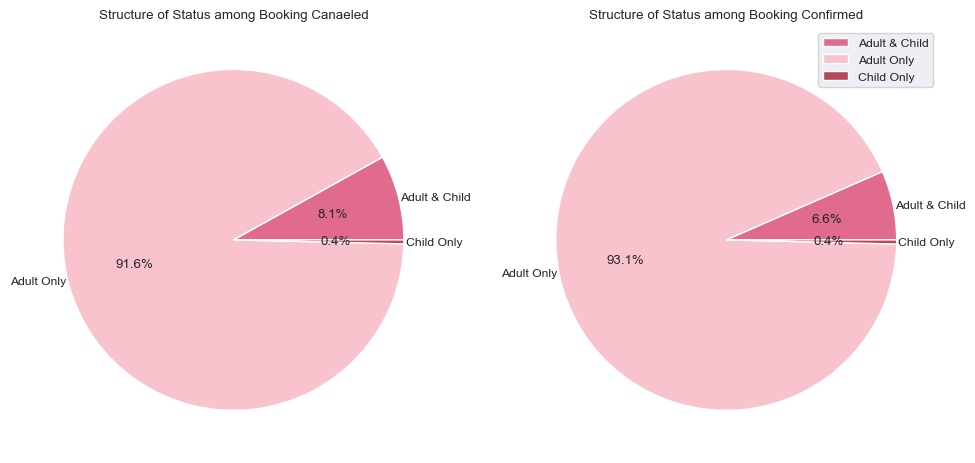

In [776]:
comp2_plot(cx, ncx,2)

### 2.2 The Number of Days Between the Date of Booking and the Arrival Date VS Booking Status

In [777]:
def leadt_plot(s1, s2, alp, loco, lolg):
    fig, ax = plt.subplots(figsize = (10,6))
    s1.plot(kind = 'hist', ax = ax, alpha = alp, color = loco[2], bins = range(0,500,50))
    s2.plot(kind = 'hist', ax = ax, alpha = alp, color = loco[1], bins = range(0,500,50))
    ax.set_title('Spread of the Number of Days Between the Date of Booking and the Arrival Date')
    ax.set_xlabel('Lead Time (Day)')
    plt.xticks(range(0,500,50))
    plt.legend(lolg)
    
    return ax

In [773]:
lead_cx = rsvn.loc[rsvn['booking_status'] == 'Canceled','lead_time']
lead_ncx = rsvn.loc[rsvn['booking_status'] == 'Not_Canceled','lead_time']

<Axes: title={'center': 'Spread of the Number of Days Between the Date of Booking and the Arrival Date'}, xlabel='Lead Time (Day)', ylabel='Frequency'>

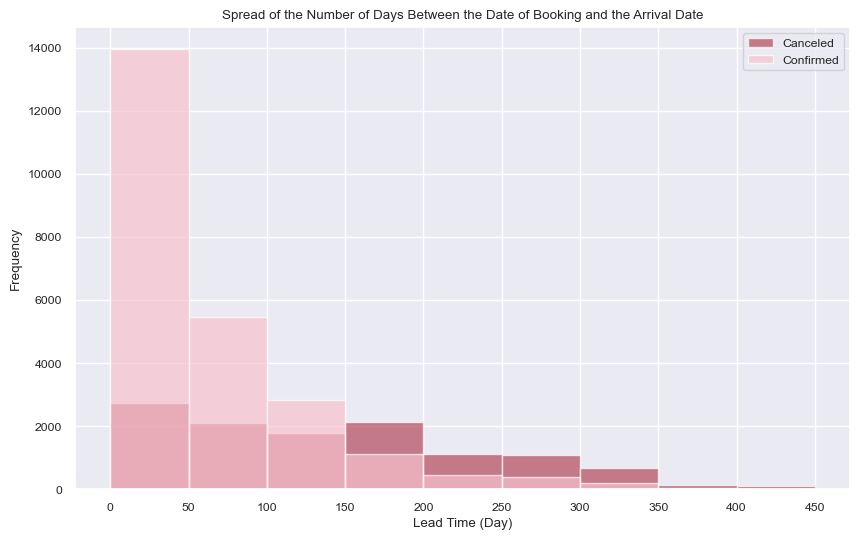

In [774]:
leadt_plot(lead_cx, lead_ncx, 0.7, colors, ['Canceled', 'Confirmed'])

### 2.4 Room Type

In [769]:
def rtype_pr_plot(df1, df2, loco):
    fig, ax = plt.subplots(figsize = (10,6))
    df1.plot(kind = 'bar', ax =ax, color = loco[0:2], xlabel = 'Room Type Reserved', ylabel = 'Count')
    ax_ = ax.twinx()
    df2.plot(kind = 'line', ax = ax_, color = loco[0:2], ylabel = 'Average Preice per Room Reserved ($)')
    ax.legend(loc = 'upper left', labels = ['Canceled','Confirmed'])
    ax_.legend(loc = 'upper right', labels = ['Canceled','Confirmed'])
    plt.xticks(np.arange(7), ['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5', 'Type 6', 'Type 7'])
    return ax1

In [770]:
rtype_count_status = rsvn[['room_type_reserved', 'booking_status']].groupby(['room_type_reserved', 'booking_status']).size()
rtype_count_status = rtype_count_status.unstack()
rtype_price_status = rsvn[['room_type_reserved', 'avg_price_per_room','booking_status']].groupby(['room_type_reserved', 'booking_status']).mean()
rtype_price_status = rtype_price_status.unstack()

<Axes: ylabel='Frequency'>

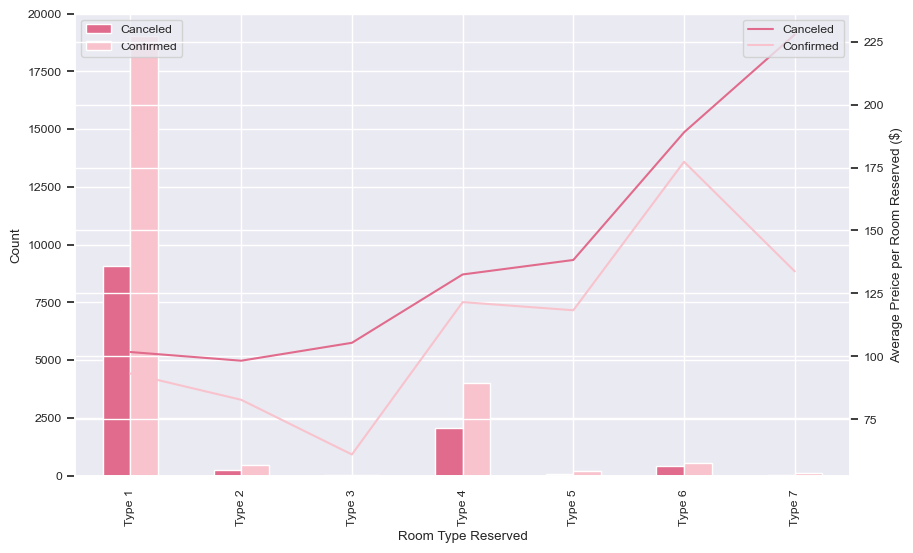

In [771]:
rtype_pr_plot(rtype_count_status,rtype_price_status, colors)

## 2.4 Average Prices per Night vs Booking Status

In [766]:
def pr_plot(stat, df, loco):
    fig, ax = plt.subplots(1,len(status), sharey=True, figsize = (10,6))
    for i in range(0,len(status)):
        df.plot(kind = 'box', ax = ax[i], xlabel = status[i])
        indi_box = ax[i]
        xtick = status[i]
        indi_box.spines[['left', 'right', 'top' ,'bottom']].set_visible(False)
        indi_box.tick_params(which="both", left=False, labelbottom=False)
    fig.suptitle('Average Prices per Night vs Booking Status')
    ax[0].set_ylabel('Average Preice per Room Reserved ($)')
    fig.tight_layout()
    return ax

In [767]:
status = rsvn['booking_status'].unique()
rsvn_pr_bk = rsvn.loc[:, ['booking_status', 'avg_price_per_room']]
rsvn_pr_bk.set_index('booking_status', inplace=True)
df1 = rsvn_pr_bk.loc[status[i]]

array([<Axes: xlabel='Not_Canceled', ylabel='Average Preice per Room Reserved ($)'>,
       <Axes: xlabel='Canceled'>], dtype=object)

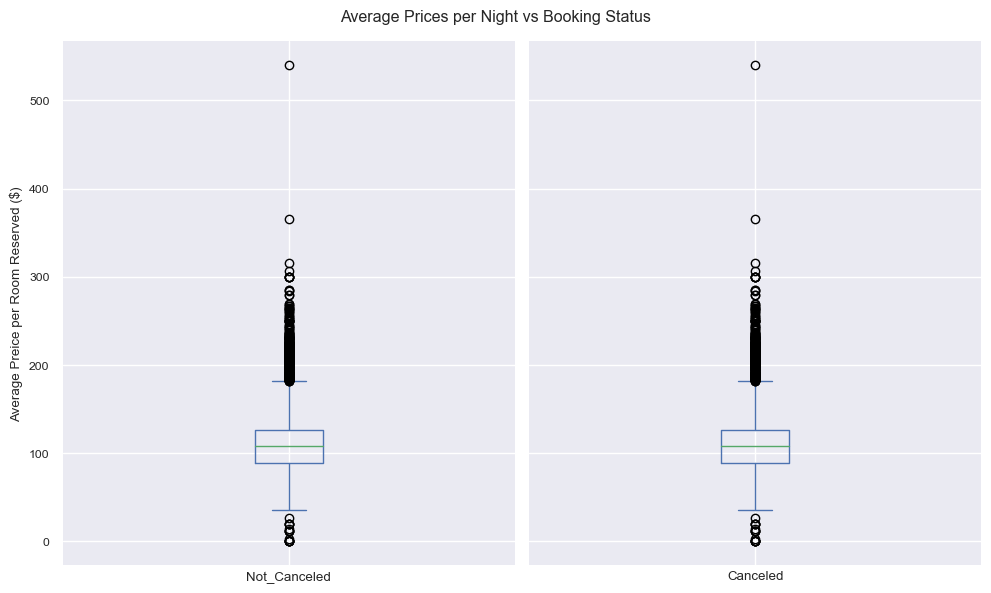

In [768]:
pr_plot(status, df1, colors)

## 2.5 repeated guest vs cx_rsvn_pcg vs booking_status

<Axes: ylabel='booking_status'>

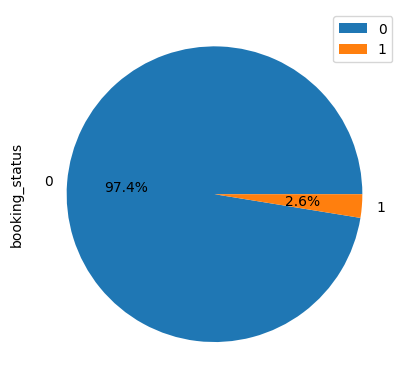

In [20]:
rsvn[['repeated_guest', 'booking_status']].groupby(['repeated_guest']).count().plot(kind = 'pie', y = 'booking_status', autopct = '%1.1f%%', legend = ['cancelled', 'confirmed'])


cx_rsvn_pcg    Axes(0.125,0.11;0.775x0.77)
dtype: object

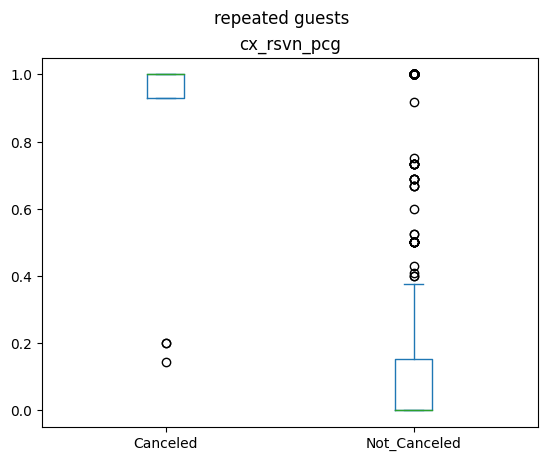

In [21]:
# rsvn[['repeated_guest', 'cx_rsvn_pcg', 'booking_status']].groupby(['repeated_guest', 'booking_status']).size()#['repeated_guest']==1
df = rsvn.loc[rsvn['repeated_guest'] == 1,['repeated_guest', 'booking_status', 'cx_rsvn_pcg']]
df[['booking_status','cx_rsvn_pcg']].plot(kind = 'box', by = 'booking_status', title = 'repeated guests')

## 2.6 Market Segment vs booking status

<Axes: xlabel='market_segment_type'>

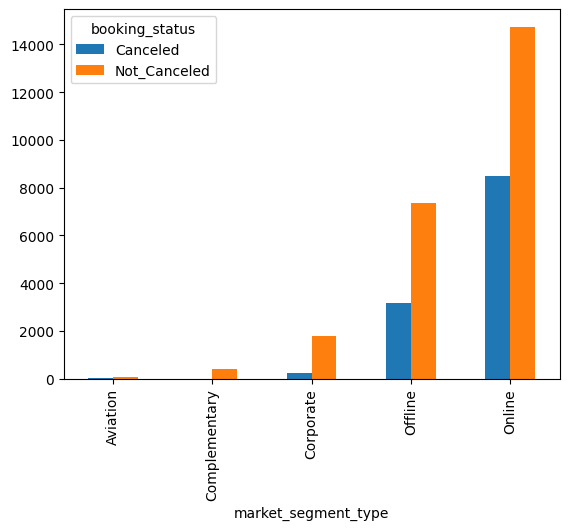

In [22]:
bb = rsvn[['market_segment_type', 'booking_status']]
bb['market_segment_type']
bb.groupby(['market_segment_type','booking_status'])['booking_status'].count().unstack().plot(kind = 'bar')

<Axes: ylabel='booking_status'>

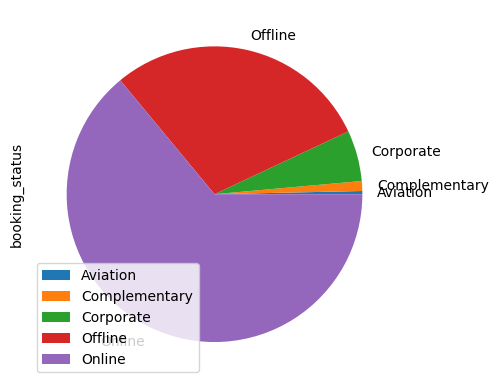

In [23]:
bb[['market_segment_type','booking_status']].groupby('market_segment_type').count().plot(kind = 'pie', y = 'booking_status')

### Data Splitting

In [24]:
X = rsvn.drop(columns=["booking_status"]) 
y = rsvn.booking_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Preliminary analysis and results


The dimension of the cleaned data frame for analysis is 36275 x 12 which contains 5 numerical variables, 3 categorical variables and 4 binary variables including the target variable `booking_status`. 

It is notable that `cx_rsvn_pcg`, the rate of previous bookings that were canceled by the customer prior to the current booking, contains many missing values. This indicates the customer never ever booked this hotel before, no matter the booking was canceled or not, so the corresponding value for `repeated_guest` would be 0.

Some children booked this hotel without the accompanies by any adults which can be seen from `0` in `no_of_adults` with `1` in `children`. So it might also be meaningful to pay additional attention to the feedback from some adults with `children = 1` and see their satisfactory of the safety of this hotel.

### Correlation between variables

TODO: Explanation 

n

/var/folders/1n/010jxkq15qv5_lk6s10mg0bh0000gn/T/ipykernel_9140/1697583311.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = X.corr()


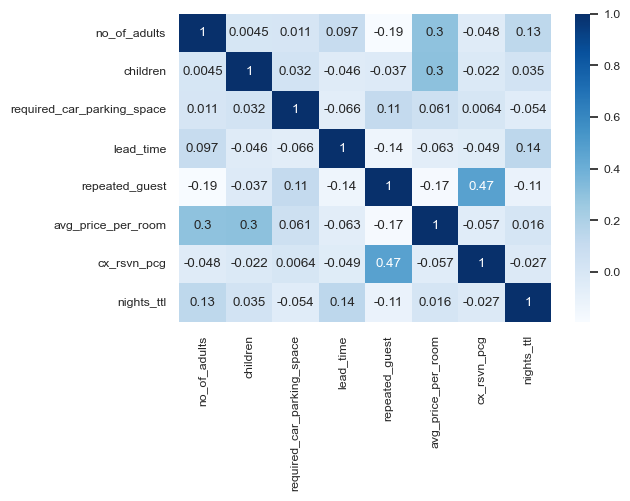

In [25]:
cor = X.corr()
plt.figure(figsize=(6, 4))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

maybe buid a network based on the correlation by filtering only the variabels with abs(cor)>0.7 see which variabel can potentially effect serval other factors simuteniuosly 

# Preprocessing

In [26]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = make_column_transformer(
    (numeric_transformer, numerical_columns),
    (categorical_transformer, categorical_columns),
    ("passthrough", binary_columns)
)

transformed_df = pd.DataFrame(ct.fit_transform(X_train))
new_labels = ['no_of_adults', 'lead_time', 'avg_price_per_room', 'cx_rsvn_pcg', 'nights_ttl', 'meal_plan_1', 'meal_plan_2',
              'meal_plan_3', 'meal_not_selected', 'room type 1', 'room type 2' , 'room type 3', 'room type 4',  'room type 5',
              'room type 6', 'room type 7', 'aviation', 'complementary', 'corporate', 'offline', 'online',
              'children', 'required_car_parking_space', 'repeated_guest']
transformed_df.columns = new_labels

/Users/jinghan/miniforge3/envs/dsci310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
transformed_df

,no_of_adults,lead_time,avg_price_per_room,cx_rsvn_pcg,nights_ttl,meal_plan_1,meal_plan_2,meal_plan_3,meal_not_selected,room type 1,...,room type 6,room type 7,aviation,complementary,corporate,offline,online,children,required_car_parking_space,repeated_guest
0,0.300222,-0.691565,1.636392,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.300222,0.147033,0.512227,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.300222,4.048843,-0.953457,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.300222,1.276811,-0.889422,-0.076401,2.253093,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.627739,1.195281,0.754136,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,0.300222,-0.493562,-1.380355,-0.076401,0.559085,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29016,-1.627739,0.193622,-0.668858,-0.076401,-0.570254,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29017,0.300222,-0.936156,0.184938,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29018,0.300222,1.486460,0.754136,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Model Selection
Selecting the most appropriate model. We observe accuracy, precision and recall scores 
* Logistic regressionrandom forest decision tree SVC

We say false negatives (inaccurately predicting one will not cancel when they will) will be prioritized for the hotel's business purposes and pay attention to recall value. 

In [28]:
y_train = y_train == "Canceled"
y_test = y_test == "Canceled"

results = {}

In [29]:
def scores(model, X_test, y_test):
    scores = []
    scores.append(np.round(accuracy_score(y_test, model.predict(X_test)),4))
    scores.append(np.round(recall_score(y_test, model.predict(X_test)),4))
    scores.append(np.round(f1_score(y_test, model.predict(X_test)),4))
    
    return pd.Series(data=scores, index=["accuracy", "recall", "f1"])

In [30]:
pipe_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs', max_iter=1000))
pipe_lr.fit(X_train, y_train)
results["logistic regression"] = scores(pipe_lr, X_test, y_test)

pipe_rf = make_pipeline(ct, RandomForestClassifier())
pipe_rf.fit(X_train, y_train)
results["random forest"] = scores(pipe_rf, X_test, y_test)

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(max_depth=5))
pipe_dt.fit(X_train, y_train)
results["decision tree"] = scores(pipe_dt, X_test, y_test)

pipe_svc = make_pipeline(ct, SVC())
pipe_svc.fit(X_train, y_train)
results["SVC"] = scores(pipe_svc, X_test, y_test)


pd.DataFrame(results).T

/Users/jinghan/miniforge3/envs/dsci310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jinghan/miniforge3/envs/dsci310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jinghan/miniforge3/envs/dsci310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jinghan/miniforge3/envs/dsci310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868

,accuracy,recall,f1
logistic regression,0.7626,0.4793,0.5736
random forest,0.8328,0.6921,0.7338
decision tree,0.7819,0.4102,0.5561
SVC,0.7891,0.4565,0.5905


# Variable Selection
Selecting the most important features to avoid overfitting on the entire training set

In [31]:
eli5.explain_weights(
    pipe_lr.named_steps["logisticregression"], feature_names=new_labels, top=30
)

NameError: name 'eli5' is not defined

In [ ]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=new_labels, top=30
)

In [ ]:
eli5.explain_weights(
    pipe_dt.named_steps["decisiontreeclassifier"], feature_names=new_labels, top=30
)

Based on above results, we will drop columns meal plans, repeated guest, and children 

The most important ones seem to be
Lead time
Avg price per room
Market segment type

No of adults 

### Force Plots

In [ ]:
# dt_explainer = shap.TreeExplainer(pipe_dt.named_steps["decisiontreeclassifier"])

In [ ]:
# X_test_enc = pd.DataFrame(
#     data=ct.transform(X_test),
#     columns=feature_names,
#     index=X_test.index
# )
# test_dt_shap_values = dt_explainer.shap_values(X_test_enc)

In [ ]:
# shap.force_plot(
#     dt_explainer.expected_value[1],
#     test_dt_shap_values[1][300, :],
#     X_test_enc.iloc[300, :],
#     matplotlib=True,
# )